Import

In [1]:
%%capture
!git clone https://github.com/AndreasHammerKU/CardiacCTAnalysis.git
%cd CardiacCTAnalysis

Imports from Github Repository

In [3]:
%%capture
!pip install dash
import numpy as np

# Custom Imports
import utils.logger as logs
from bin.Environment import MedicalImageEnvironment
from bin.DataLoader import DataLoader
from bin.Trainer import Trainer
from utils.parser import Experiment, ExperimentConfig

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

dataset_folder = '/content/drive/MyDrive/_2025_aortic_valves'
logs_folder = '/content/drive/MyDrive/logs'

Hyperparameters

In [4]:
debug = True
logger = logs.setup_logger(debug)

dataLoader = DataLoader(dataset_folder, logger=logger, seed=1, include_pathological=True)

DEBUG:Logger:Loaded 151 normal images | Loaded 61 pathological images | Loaded 68 external images
DEBUG:Logger:Loaded 151 normal landmarks | Loaded 61 pathological landmarks | Loaded 68 external landmarks
DEBUG:Logger:Train split ['p57', 'p22', 'n132', 'n130', 'p11', 'n2', 'n34', 'p21', 'p56', 'n131', 'n135', 'n111', 'p8', 'p20', 'p33', 'n11', 'n7', 'n83', 'n74', 'n133', 'n5', 'n82', 'n138', 'n23', 'n43', 'n38', 'n92', 'p36', 'p2', 'n110', 'n81', 'p51', 'n116', 'p25', 'n35', 'p12', 'n127', 'n117', 'n9', 'p14', 'p32', 'n31', 'n129', 'n46', 'n72', 'n108', 'p39', 'n115', 'n70', 'n45', 'p50', 'n89', 'n41', 'n40', 'n112', 'n114', 'n150', 'n98', 'p55', 'n124', 'n84', 'p30', 'p10', 'n107', 'n102', 'n128', 'n109', 'n12', 'p28', 'n6', 'n101', 'n54', 'n137', 'n61', 'p43', 'n86', 'n57', 'p52', 'n55', 'p24', 'n146', 'p44', 'p48', 'n63', 'n96', 'n140', 'n18', 'n95', 'n148', 'p42', 'n27', 'n22', 'p60', 'n58', 'n143', 'p46', 'n87', 'n97', 'p16', 'n39', 'p9', 'p41', 'n14', 'n29', 'p45', 'p6', 'n145', 

In [5]:
def run_training(config, logger, dataLoader):
  logger.create_dataframes()
  train_env = MedicalImageEnvironment(logger=logger,
                                dataLoader=dataLoader,
                                image_list=dataLoader.train,
                                agents=config.agents,
                                n_sample_points=config.n_sample_points)
  eval_env = MedicalImageEnvironment(logger=logger,
                                task="eval",
                                dataLoader=dataLoader,
                                image_list=dataLoader.val,
                                agents=config.agents,
                                n_sample_points=config.n_sample_points)
  agent = Trainer(train_environment=train_env,
                   eval_environment=eval_env,
                   task="train",
                   logger=logger,
                   dataLoader=dataLoader,
                   action_dim=train_env.n_actions,
                   attention=config.attention,
                   model_type=config.model_type,
                   rl_framework=config.rl_framework,
                   agents=config.agents,
                   max_steps=config.max_steps,
                   episodes=config.episodes,
                   decay=config.decay,
                   image_interval=config.image_interval,
                   evaluation_steps=config.evaluation_steps,
                   evaluation_interval=config.evaluation_interval,
                   experiment=config.experiment)

  agent.train()
  logger.save_to_hdf5(config_obj=config, directory=logs_folder)
  train_env.visualize_current_state()
  eval_env.visualize_current_state()

def run_test(config, logger, dataLoader, external=False):
  logger.create_dataframes()
  test_env = MedicalImageEnvironment(logger=logger,
                                task="test",
                                dataLoader=dataLoader,
                                image_list=dataLoader.test_external if external else dataLoader.test,
                                agents=config.agents,
                                n_sample_points=config.n_sample_points)
  agent = Trainer(test_environment=test_env,
                   task="test",
                   logger=logger,
                   dataLoader=dataLoader,
                   action_dim=test_env.n_actions,
                   attention=config.attention,
                   agents=config.agents,
                   model_name=f"{config.model_type}-{config.experiment.name}",
                   model_type=config.model_type,
                   rl_framework=config.rl_framework,
                   max_steps=config.max_steps,
                   episodes=config.episodes,
                   evaluation_steps=config.evaluation_steps,
                   evaluation_interval=config.evaluation_interval,
                   experiment=config.experiment
                   )

  agent.test()
  logger.save_to_hdf5(config_obj=config, directory=logs_folder)
  test_env.visualize_current_state()

Experiment 1: Network 3D - work alone

In [8]:
config = ExperimentConfig(model_type="Network3D",
                          rl_framework="DQN",
                          max_steps=1,
                          image_interval=2,
                          episodes=6,
                          agents=6,
                          evaluation_steps=40,
                          evaluation_interval=5,
                          decay=200, # EPSILON = MIN_EPS - (MAX_EPS - MIN_EPS) * e^(-1 * current_step / decay)
                          attention=False,
                          experiment=Experiment.WORK_ALONE,
                          n_sample_points=5
                          )

DEBUG:Logger:Creating new empty DataFrames.
DEBUG:Logger:Initialized Trainer with parameters:
Episodes: 6
Max Steps: 1
Decay: 200
Max epsilon: 1.0
Min epsilon: 0.01
Gamma: 0.9
Learning Rate: 0.001
Model Type: Network3D
Experiment: WORK_ALONE
Tau: 0.005
DEBUG:Logger:Loading image n39
INFO:Logger:Episode 1: Total Reward = -0.62 | Final Avg Distance 36.74 | Average error in mm [3.92 7.08 6.19 6.65 7.88 5.16] | Worst Error in mm [ 5.94 10.73  9.38 10.07 11.94  7.82] Avg Closest Point = 36.30 | Avg Furthest Point = 36.81
DEBUG:Logger:Inserting row into train_df: episode=1
INFO:Logger:Episode 2: Total Reward = 0.00 | Final Avg Distance 36.12 | Average error in mm [4.12 6.83 6.24 6.3  8.23 5.16] | Worst Error in mm [ 6.24 10.36  9.46  9.55 12.47  7.82] Avg Closest Point = 35.86 | Avg Furthest Point = 36.35
DEBUG:Logger:Inserting row into train_df: episode=2
DEBUG:Logger:Loading image n45
INFO:Logger:Episode 3: Total Reward = 0.04 | Final Avg Distance 33.05 | Average error in mm [4.98 5.4  6.0

average error across all agents is 7.430203437805176 mm


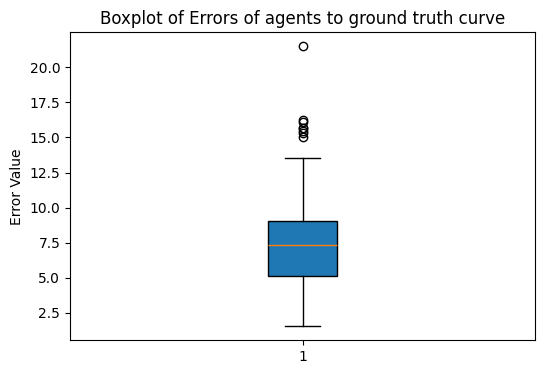

average error across all agents is 11.259033203125 mm


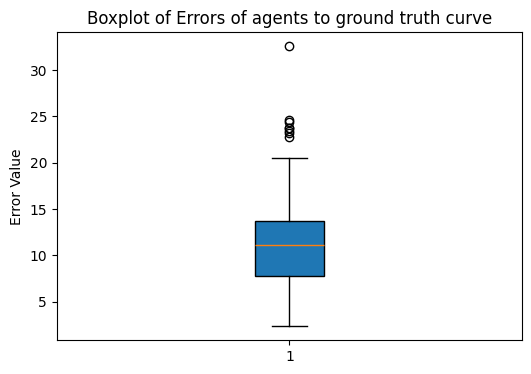

INFO:Logger:Episode 6: Total Reward = 0.17 | Final Avg Distance 38.58 | Average error in mm [ 4.57  5.32  4.98  7.08 10.51  5.79] | Worst Error in mm [ 6.93  8.06  7.54 10.72 15.93  8.77] Avg Closest Point = 38.35 | Avg Furthest Point = 38.89
DEBUG:Logger:Inserting row into train_df: episode=6


TypeError: MedicalLogger.save_to_hdf5() got an unexpected keyword argument 'directory'

In [9]:
run_training(config, logger=logger, dataLoader=dataLoader)

INFO:Logger:Evaluation Episode 1: Total Reward = 15.53 | Final Average Distance = 7.80 | Error in mm [1.47 3.   0.74 3.12 1.83 2.91] | Closest Point = [ 5.1   3.16  2.24 10.68  6.78 11.66] | Furthest Point = [24.08 19.03 18.22 25.55 25.5  23.62]
INFO:Logger:Evaluation Episode 2: Total Reward = 15.49 | Final Average Distance = 7.26 | Error in mm [1.18 1.93 2.52 2.92 0.78 4.12] | Closest Point = [2.83 3.74 5.39 8.25 2.24 9.27] | Furthest Point = [13.34 25.57 23.43 21.61 25.73 21.93]
INFO:Logger:Evaluation Episode 3: Total Reward = 15.61 | Final Average Distance = 11.46 | Error in mm [2.13 3.93 1.06 4.13 1.87 3.17] | Closest Point = [ 7.35  5.2   2.83 16.91  7.28 12.41] | Furthest Point = [27.15 22.34 22.58 29.7  25.48 30.68]
INFO:Logger:Evaluation Episode 4: Total Reward = 24.51 | Final Average Distance = 7.37 | Error in mm [2.04 0.99 0.84 3.   1.81 2.06] | Closest Point = [ 9.85  3.61  3.32 11.58  6.48  9.  ] | Furthest Point = [23.43 33.85 32.26 33.56 35.17 28.37]
INFO:Logger:Evaluatio

[ 0.97108006  1.9785082   0.49159804  2.0620306   1.210821    1.917928
  0.7818658   1.274625    1.6655579   1.929531    0.5178927   2.72145
  1.4077717   2.591141    0.69950324  2.7231274   1.2362146   2.0897446
  1.3471905   0.65426123  0.5552713   1.9778641   1.194452    1.362271
  1.3907573   0.619203    1.1166018   4.029718    5.816435    2.669893
  1.410734    0.5586224   0.36064264  0.0989899   0.36064264  1.5485215
  0.40575564  3.0898285   1.491036    1.7941933   1.236859    1.8869957
  1.7807871   0.6063131   1.7673821  10.425905    1.8323443   5.667172
  1.559091    2.0684764   2.3262627   5.81875     1.1662247   1.4394782
  0.8622951   0.6877739   0.36734557  1.9877903   2.011249    0.81537783]


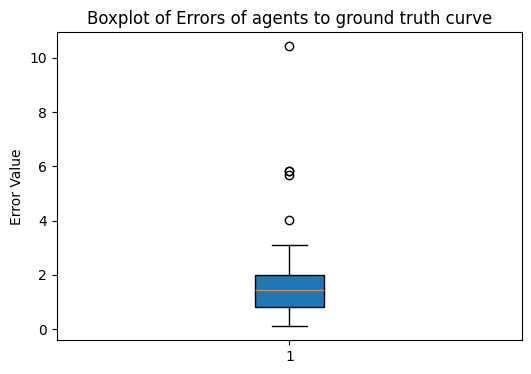

[ 0.98000705  1.9966964   0.49611723  2.0809865   1.221952    1.9355593
  0.7890534   1.2863425   1.6808691   1.9472688   0.52265364  2.746468
  1.4207132   2.614961    0.7059337   2.7481608   1.247579    2.1089551
  1.359575    0.66027576  0.56037587  1.9960463   1.2054325   1.3747941
  1.4035424   0.6248952   1.1268666   4.0667624   5.8699045   2.6944368
  1.4237027   0.5637578   0.36395797  0.0998999   0.36395797  1.5627568
  0.4094857   3.118233    1.504743    1.8106871   1.2482293   1.9043425
  1.7971576   0.6118869   1.7836295  10.521749    1.8491888   5.7192693
  1.5734234   2.0874918   2.3476477   5.872241    1.1769457   1.4527111
  0.87022203  0.6940965   0.37072253  2.006064    2.0297382   0.8228735 ]


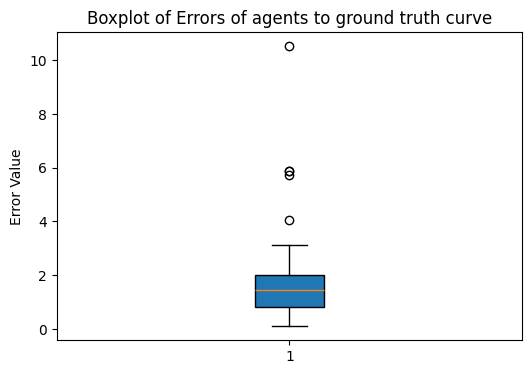

[ 1.4714836  2.9980457  0.7449215  3.1246076  1.8347646  2.906248
  1.184766   1.931447   2.5238302  2.92383    0.784766   4.1238303
  2.1332052  3.9263716  1.0599616  4.126372   1.8732436  3.1666026
  2.0414062  0.991406   0.841406   2.9970696  1.8099606  2.0642576
  2.107423   0.938282   1.6919936  6.106256   8.81368    4.0457053
  2.137694   0.846484   0.546484   0.15       0.546484   2.3464842
  0.614844   4.682036   2.259376   2.7187521  1.87422    2.859376
  2.6984375  0.91875    2.678125  15.798437   2.7765625  8.5875
  2.3625     3.134375   3.525      8.817187   1.7671875  2.18125
  1.306641   1.0421879  0.556641   3.012111   3.047658   1.2355471]


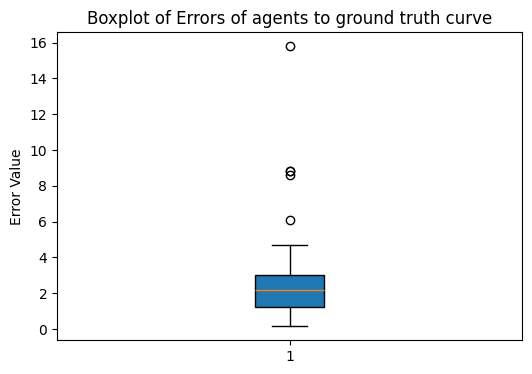

INFO:Logger:===== Evaluation Summary =====
INFO:Logger:Average Closest Distance Across Agents: 5.93
INFO:Logger:Average Furthest Distance Across Agents: 26.95


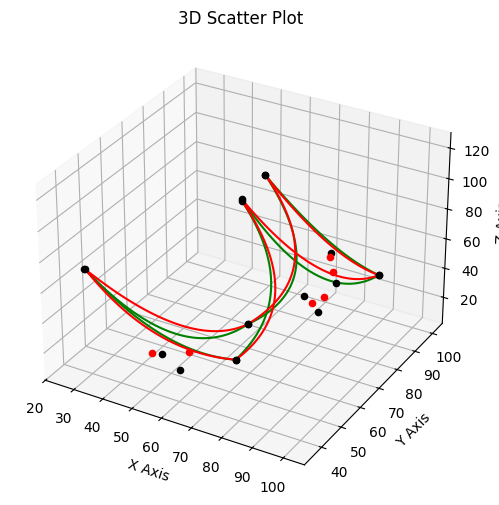

In [ ]:
run_test(config)

Experiment 2: Network 3D - share positions

In [ ]:
config.experiment = Experiment.SHARE_POSITIONS

In [ ]:
run_training(config)

In [ ]:
run_test(config)

Experiment 3: Network 3D share pairwise positions

In [ ]:
config.experiment = Experiment.SHARE_PAIRWISE

INFO:Logger:Episode 1: Total Reward = -23.39 | Final Avg Distance 50.23 | Distances in mm [ 4.61  3.71 14.68 10.96 15.83  2.04] | Avg Closest Point = 10.19 | Avg Furthest Point = 63.32
INFO:Logger:Episode 2: Total Reward = -2.56 | Final Avg Distance 29.40 | Distances in mm [9.12 6.61 2.36 2.32 6.34 5.85] | Avg Closest Point = 7.07 | Avg Furthest Point = 42.02
INFO:Logger:Episode 3: Total Reward = 8.12 | Final Avg Distance 21.54 | Distances in mm [5.87 3.22 3.26 5.25 2.72 4.27] | Avg Closest Point = 10.59 | Avg Furthest Point = 33.51
INFO:Logger:Episode 4: Total Reward = 12.56 | Final Avg Distance 17.10 | Distances in mm [7.65 2.78 1.12 1.13 2.09 3.05] | Avg Closest Point = 6.91 | Avg Furthest Point = 33.55
INFO:Logger:Episode 5: Total Reward = 11.48 | Final Avg Distance 16.54 | Distances in mm [3.03 4.38 4.31 1.61 2.47 1.52] | Avg Closest Point = 6.42 | Avg Furthest Point = 32.54
INFO:Logger:Episode 6: Total Reward = 7.13 | Final Avg Distance 20.90 | Distances in mm [3.62 5.04 3.66 4.8

[2.6540384  0.5501159  1.5951813  2.129057   2.4536097  1.3533779
 1.8447177  2.4666264  1.4169216  0.85559213 2.5333931  3.2600925
 1.6611745  1.9322369  1.2265469  4.325009   2.7628243  2.2334602
 0.5279461  0.87518424 1.6042039  0.90972775 3.1353254  4.6744375
 2.9305134  4.0070286  3.190362   3.340909   1.6003367  2.9387627
 1.127557   3.9507031  2.0571342  0.9984062  1.2652149  2.3541038
 0.6372468  2.4226723  1.9117404  2.043727   2.594359   4.3003836
 1.7980576  2.7340794  2.1819012  6.8217926  4.8554     7.721466
 5.99469    2.776358   3.1746378  6.792023   4.7109146  5.2549725
 3.0427797  1.5277702  3.8861277  3.7998984  2.1990457  3.4515    ]


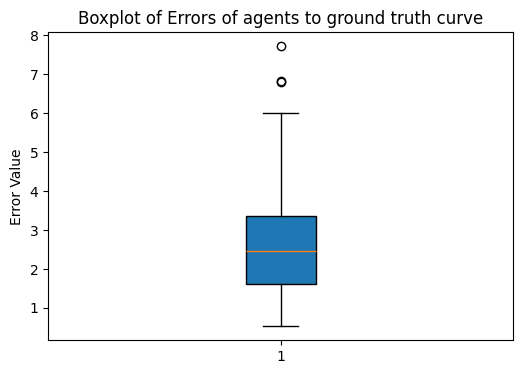

[2.6784365  0.55517304 1.6098456  2.148629   2.4761655  1.3658195
 1.861676   2.4893017  1.4299473  0.8634575  2.5566823  3.290062
 1.6764455  1.9499997  1.2378224  4.364768   2.7882226  2.253992
 0.5327995  0.8832297  1.6189511  0.9180907  3.164148   4.717409
 2.9574533  4.0438647  3.2196906  3.3716216  1.6150484  2.9657784
 1.1379225  3.9870214  2.076045   1.0075843  1.2768459  2.3757448
 0.6431049  2.4449434  1.9293149  2.0625148  2.6182086  4.3399167
 1.8145869  2.7592132  2.2019591  6.8845043  4.9000354  7.7924485
 6.049798   2.8018806  3.2038217  6.854461   4.7542214  5.303281
 3.0707514  1.5418148  3.9218524  3.8348305  2.2192612  3.4832292 ]


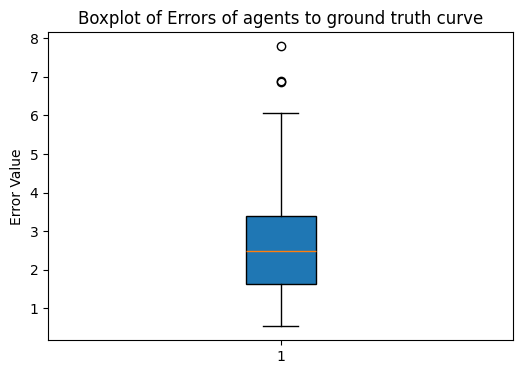

[ 4.0216804   0.83359396  2.417188    3.226173    3.71797     2.050782
  2.795312    3.737694    2.14707     1.296484    3.838866    4.940038
  2.517188    2.9279304   1.8585941   6.5537124   4.1865244   3.384376
  0.8         1.326172    2.43086     1.378516    4.750978    7.0832043
  4.440625    6.071875    4.834375    5.0625      2.425       4.453125
  1.7085941   5.9865246   3.117188    1.512891    1.9171879   3.567188
  0.965624    3.67109     2.896872    3.0968719   3.931248    6.516398
  2.7246075   4.142967    3.3062482  10.337104    7.3574176  11.700385
  9.08379     4.207032    4.810548   10.291994    7.138478    7.962892
  4.6107426   2.3150396   5.888673    5.7580094   3.3322275   5.230079  ]


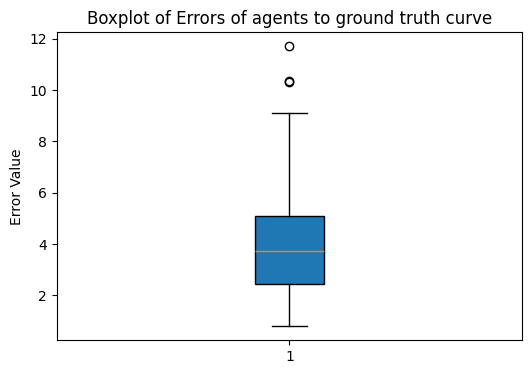

INFO:Logger:===== Evaluation Summary =====
INFO:Logger:Average Closest Distance Across Agents: 11.22
INFO:Logger:Average Furthest Distance Across Agents: 28.93
INFO:Logger:Episode 11: Total Reward = 17.28 | Final Avg Distance 8.46 | Distances in mm [0.82 0.63 0.41 3.06 1.67 1.24] | Avg Closest Point = 1.38 | Avg Furthest Point = 27.31
INFO:Logger:Episode 12: Total Reward = 24.22 | Final Avg Distance 1.52 | Distances in mm [0.   0.42 0.21 0.21 0.21 0.41] | Avg Closest Point = 0.00 | Avg Furthest Point = 27.53
INFO:Logger:Episode 13: Total Reward = 22.95 | Final Avg Distance 5.80 | Distances in mm [1.06 0.27 1.85 0.99 1.06 3.14] | Avg Closest Point = 3.57 | Avg Furthest Point = 30.46
INFO:Logger:Episode 14: Total Reward = 18.63 | Final Avg Distance 10.12 | Distances in mm [1.46 1.04 1.16 2.1  3.55 4.37] | Avg Closest Point = 0.67 | Avg Furthest Point = 29.39
INFO:Logger:Episode 15: Total Reward = 16.01 | Final Avg Distance 7.45 | Distances in mm [1.18 0.97 2.51 1.2  1.82 1.06] | Avg Clos

[1.6365561  1.6503477  1.4523679  2.129057   0.6628974  2.4860904
 3.1614892  2.105597   0.62500244 2.1723638  1.9751574  4.385845
 2.117456   1.8978225  1.4330338  1.8978225  4.226019   2.5950053
 1.6772861  1.2569658  1.5554824  0.5035854  1.14934    2.3474016
 2.6521044  1.3343014  2.3963804  1.9921718  3.4481483  3.7286196
 2.0830414  3.3567636  2.6336734  2.1947923  0.73159736 2.3281965
 1.165193   1.1595215  0.13198653 2.6000304  1.5611526  4.1271544
 2.1710749  2.637151   1.2350531  3.9085522  5.6715517  1.9313339
 2.1302164  2.776358   4.958003   2.3305166  3.966557   6.001651
 2.0528805  2.5261765  1.9666514  4.1529365  1.72575    3.5462363 ]


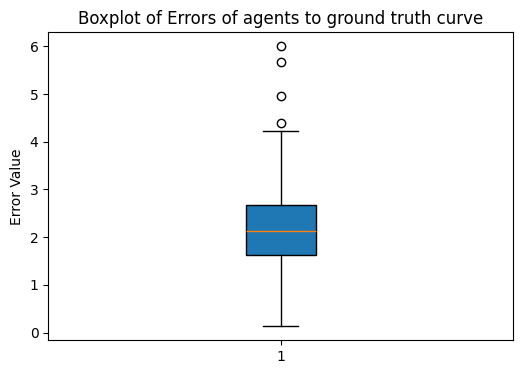

[1.6516007  1.6655191  1.4657193  2.148629   0.6689913  2.5089447
 3.1905525  2.1249535  0.630748   2.192334   1.9933147  4.4261637
 2.1369214  1.9152689  1.4462075  1.9152689  4.2648683  2.618861
 1.6927053  1.268521   1.5697817  0.5082148  1.1599058  2.368981
 2.6764848  1.3465674  2.41841    2.0104854  3.4798465  3.7628963
 2.1021907  3.3876219  2.6578844  2.2149687  0.73832285 2.3495994
 1.1759044  1.1701808  0.13319987 2.6239321  1.5755041  4.1650944
 2.1910334  2.6613941  1.2464068  3.944483   5.7236896  1.9490883
 2.1497993  2.8018806  5.003581   2.3519406  4.003021   6.0568233
 2.0717525  2.5493991  1.9847306  4.191114   1.7416146  3.5788364 ]


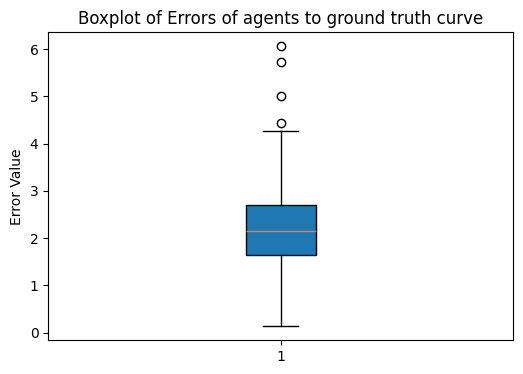

[2.4798834 2.500782  2.200782  3.226173  1.0044925 3.767188  4.790624
 3.190624  0.94707   3.291796  2.992968  6.645898  3.208594  2.875782
 2.171485  2.875782  6.4037123 3.9322276 2.541602  1.904688  2.357032
 0.763086  1.741602  3.557032  4.01875   2.021875  3.63125   3.01875
 5.225     5.65      3.1564455 5.0865245 3.9908214 3.325782  1.108594
 3.5279305 1.765624  1.75703   0.2       3.939842  2.365624  6.253902
 3.289843  3.9960911 1.8714836 5.922653  8.594137  2.926562  3.22793
 4.207032  7.5128922 3.531446  6.010548  9.094338  3.1107426 3.8279305
 2.980079  6.29297   2.6150396 5.3736334]


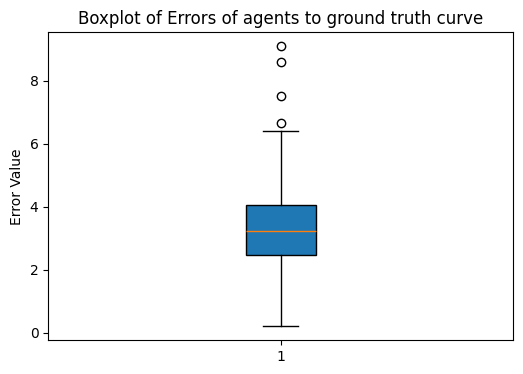

INFO:Logger:===== Evaluation Summary =====
INFO:Logger:Average Closest Distance Across Agents: 10.66
INFO:Logger:Average Furthest Distance Across Agents: 27.50
INFO:Logger:Episode 21: Total Reward = 24.87 | Final Avg Distance 3.18 | Distances in mm [0.74 0.47 0.34 0.37 0.73 0.34] | Avg Closest Point = 0.50 | Avg Furthest Point = 28.89
INFO:Logger:Episode 22: Total Reward = 26.38 | Final Avg Distance 1.67 | Distances in mm [0.34 0.24 0.1  0.34 0.24 0.34] | Avg Closest Point = 0.00 | Avg Furthest Point = 31.07
INFO:Logger:Episode 23: Total Reward = 20.07 | Final Avg Distance 5.07 | Distances in mm [0.39 0.92 2.23 1.05 0.52 0.66] | Avg Closest Point = 1.69 | Avg Furthest Point = 27.31
INFO:Logger:Episode 24: Total Reward = 23.71 | Final Avg Distance 1.43 | Distances in mm [0.13 0.39 0.13 0.52 0.26 0.13] | Avg Closest Point = 0.24 | Avg Furthest Point = 26.01
INFO:Logger:Episode 25: Total Reward = 16.67 | Final Avg Distance 7.13 | Distances in mm [1.04 0.58 0.74 3.54 1.84 0.2 ] | Avg Close

[2.1339543 1.8483275 0.9736587 1.9034939 1.3120033 2.2605274 1.2833883
 1.8750073 1.3167716 1.3167716 3.7197251 1.0543454 1.127557  2.293782
 1.3642049 1.4933558 2.2980356 1.0285671 1.1249793 1.066075  1.1249793
 1.7950947 1.6285646 2.0387022 0.8042929 1.8746213 2.408754  4.6628366
 3.2006733 1.8498738 2.5822446 3.2276127 1.5320238 3.5547435 1.0672351
 1.8978225 1.3951372 1.6761247 1.1368356 2.3530717 2.3077    1.0218635
 1.1272986 2.169785  2.673499  1.9906242 3.6566951 2.8539498 3.7140548
 2.776358  1.685922  1.3390707 4.413172  2.4801617 1.6913354 2.2334602
 2.6982489 3.0253794 1.794579  1.5579311]


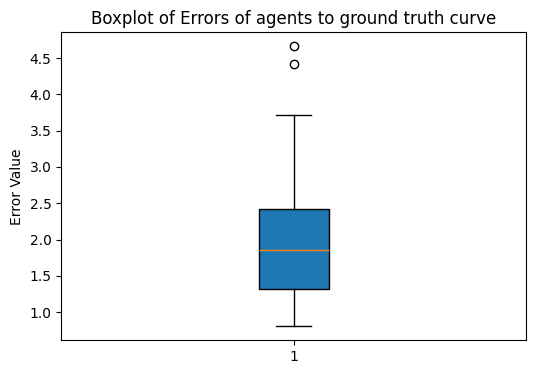

[2.1535716  1.8653189  0.98260945 1.9209925  1.3240643  2.2813082
 1.2951863  1.892244   1.3288765  1.3288765  3.7539198  1.0640378
 1.1379225  2.3148685  1.3767458  1.5070839  2.3191612  1.0380225
 1.135321   1.0758753  1.135321   1.8115968  1.6435359  2.0574439
 0.8116867  1.8918544  2.4308975  4.7057014  3.2300968  1.8668795
 2.6059828  3.257284   1.5461074  3.5874217  1.0770462  1.9152689
 1.4079626  1.6915331  1.1472864  2.3747032  2.3289144  1.0312574
 1.1376617  2.1897316  2.6980762  2.0089238  3.6903107  2.8801858
 3.7481978  2.8018806  1.7014205  1.3513806  4.4537416  2.5029614
 1.7068837  2.253992   2.7230535  3.0531914  1.8110763  1.572253  ]


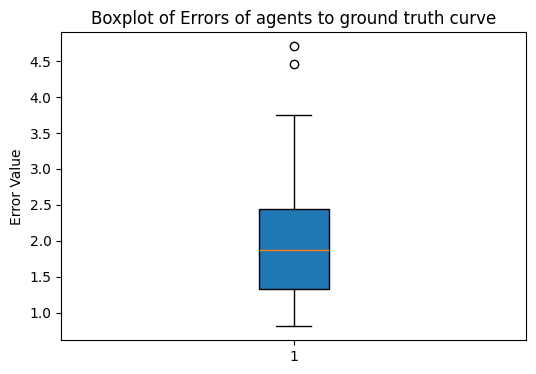

[3.2335942 2.800782  1.475391  2.884376  1.9880865 3.4253912 1.944726
 2.8412101 1.995312  1.995312  5.6365223 1.597656  1.7085941 3.475782
 2.067188  2.262891  3.4822276 1.558594  1.704688  1.61543   1.704688
 2.720118  2.467774  3.089258  1.21875   2.840625  3.65      7.065625
 4.85      2.8031251 3.9128911 4.8908215 2.321485  5.3865247 1.617188
 2.875782  2.11406   2.539842  1.722654  3.565624  3.496872  1.5484359
 1.7082026 3.2878885 4.0511694 3.016405  5.541013  4.324608  5.62793
 4.207032  2.554688  2.029102  6.687306  3.758204  2.562891  3.384376
 4.088673  4.584376  2.7193365 2.3607426]


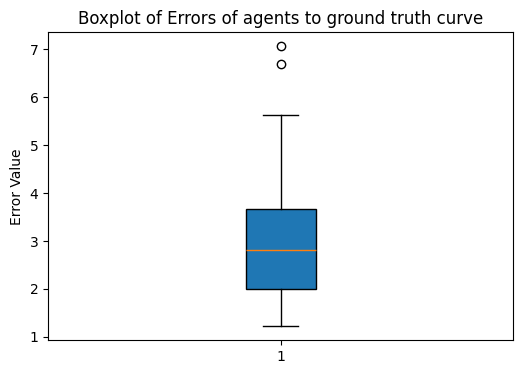

INFO:Logger:===== Evaluation Summary =====
INFO:Logger:Average Closest Distance Across Agents: 10.52
INFO:Logger:Average Furthest Distance Across Agents: 27.92
INFO:Logger:Episode 31: Total Reward = 22.66 | Final Avg Distance 5.36 | Distances in mm [1.12 1.05 0.66 0.99 0.53 0.99] | Avg Closest Point = 1.31 | Avg Furthest Point = 29.65
INFO:Logger:Episode 32: Total Reward = 25.76 | Final Avg Distance 2.26 | Distances in mm [0.23 0.39 0.23 0.59 0.49 0.1 ] | Avg Closest Point = 0.71 | Avg Furthest Point = 29.70
INFO:Logger:Episode 33: Total Reward = 24.28 | Final Avg Distance 5.73 | Distances in mm [1.35 0.84 1.19 0.88 1.   1.26] | Avg Closest Point = 2.22 | Avg Furthest Point = 32.61
INFO:Logger:Episode 34: Total Reward = 28.08 | Final Avg Distance 1.93 | Distances in mm [0.38 0.13 0.48 0.48 0.45 0.13] | Avg Closest Point = 0.33 | Avg Furthest Point = 32.11
INFO:Logger:Episode 35: Total Reward = 18.65 | Final Avg Distance 2.97 | Distances in mm [0.66 0.4  1.19 0.4  0.66 0.  ] | Avg Close

[1.2405965  4.155127   0.9460755  6.9997993  3.4435089  1.6390048
 2.4363368  0.85559213 2.0753074  5.0364966  3.783398   1.5155249
 1.5235167  1.8978225  2.1302168  4.9274554  3.098462   0.83058727
 1.3889524  0.13198653 1.8925377  3.8541625  2.4408493  3.3789332
 2.406692   3.204798   2.9284513  4.409175   4.015278   1.5982745
 3.2794275  3.4944217  2.5219228  4.1916046  2.9263895  1.3986194
 1.1425071  0.8955484  2.1870565  4.553014   3.8234808  1.2801651
 2.662673   4.533427   2.876892   2.421642   4.220989   6.246672
 1.9836652  5.2549725  2.1831918  5.0569925  8.378955   1.0912092
 2.8188925  1.1318105  2.362611   3.4642608  5.383737   1.6267601 ]


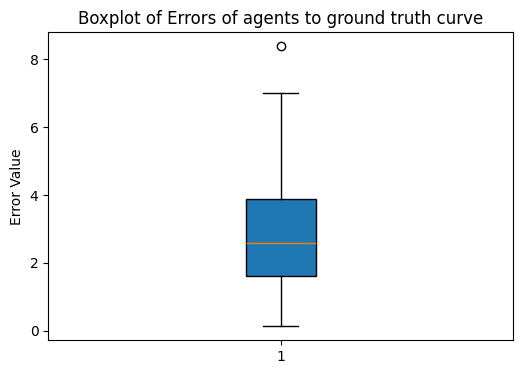

[1.2520012  4.1933246  0.95477265 7.0641475  3.4751647  1.6540719
 2.4587338  0.8634575  2.0943854  5.0827966  3.8181782  1.5294569
 1.5375221  1.9152689  2.1497996  4.972753   3.1269457  0.83822274
 1.4017208  0.13319987 1.9099356  3.8895934  2.4632878  3.409995
 2.4288163  3.2342594  2.955372   4.449708   4.05219    1.6129671
 3.3095748  3.5265453  2.5451064  4.2301373  2.9532914  1.4114767
 1.15301    0.90378106 2.2071617  4.594869   3.8586297  1.2919334
 2.6871505  4.575102   2.903339   2.443904   4.2597923  6.3040967
 2.0019007  5.303281   2.2032616  5.103481   8.455982   1.1012405
 2.8448062  1.1422151  2.3843303  3.496107   5.433229   1.6417147 ]


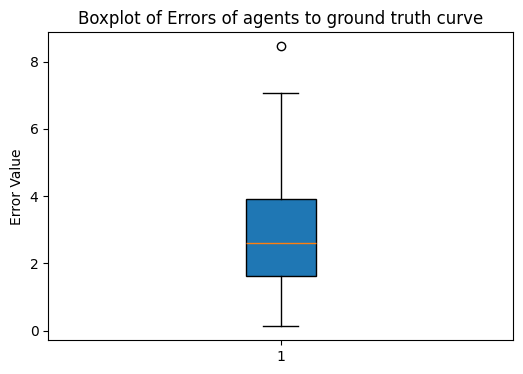

[ 1.8798835  6.2962894  1.433594  10.606838   5.21797    2.483594
  3.691796   1.296484   3.144726   7.631834   5.733006   2.296484
  2.308594   2.875782   3.2279305  7.4666033  4.6951184  1.258594
  2.104688   0.2        2.867774   5.8402357  3.698634   5.120118
  3.646875   4.85625    4.4375     6.68125    6.084375   2.421875
  4.9693365  5.2951183  3.821485   6.351564   4.434376   2.1193366
  1.731248   1.35703    3.31406    6.89921    5.793744   1.939842
  4.034765   6.8695292  4.359372   3.6695292  6.396091   9.46562
  3.00586    7.962892   3.308204   7.662892  12.696682   1.653516
  4.271485   1.7150395  3.580079   5.2494154  8.15801    2.4650395]


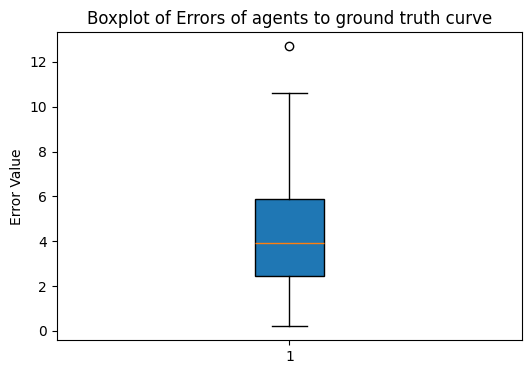

INFO:Logger:===== Evaluation Summary =====
INFO:Logger:Average Closest Distance Across Agents: 11.69
INFO:Logger:Average Furthest Distance Across Agents: 27.65


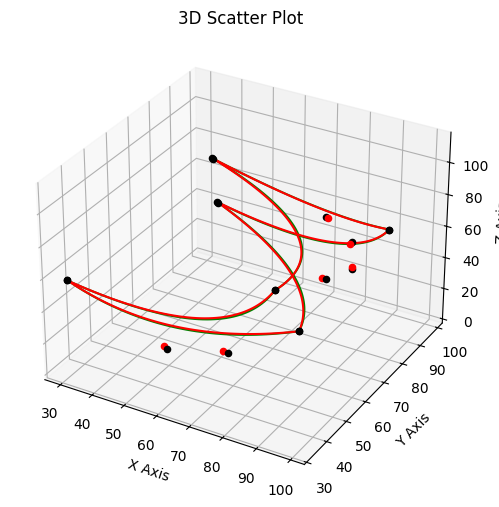

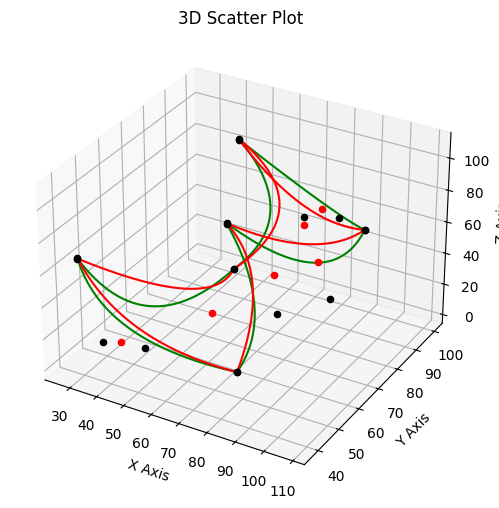

In [ ]:
run_training(config)

INFO:Logger:Evaluation Episode 1: Total Reward = 13.99 | Final Average Distance = 9.34 | Error in mm [2.27 1.54 3.31 1.29 3.03 2.91] | Closest Point = [ 5.    3.16 11.18  5.2   8.77 11.18] | Furthest Point = [24.08 19.03 17.83 25.32 25.5  23.62]
INFO:Logger:Evaluation Episode 2: Total Reward = 13.18 | Final Average Distance = 9.58 | Error in mm [0.4  1.58 4.07 5.26 2.72 3.34] | Closest Point = [ 0.    5.48 11.18 15.52  5.83  9.11] | Furthest Point = [13.34 25.57 23.43 21.61 25.73 21.93]
INFO:Logger:Evaluation Episode 3: Total Reward = 5.78 | Final Average Distance = 21.30 | Error in mm [4.39 7.95 9.97 5.68 4.42 2.75] | Closest Point = [14.56 10.34 20.25 17.89 10.   10.82] | Furthest Point = [27.15 30.64 33.79 29.53 25.48 30.68]
INFO:Logger:Evaluation Episode 4: Total Reward = 21.01 | Final Average Distance = 10.87 | Error in mm [0.77 2.07 1.19 5.07 2.39 3.36] | Closest Point = [ 4.   11.    5.2  20.62  9.22 12.65] | Furthest Point = [23.43 33.85 31.92 33.62 35.17 28.37]
INFO:Logger:Eva

[1.4990262  1.0195441  2.1819012  0.8512095  2.0027401  1.917928
 0.26397306 1.0408121  2.6862633  3.4731557  1.7925177  2.2035575
 2.8991942  5.2441463  6.5770326  3.7482145  2.9167247  1.8124965
 0.51003    1.3688443  0.78341204 3.3467083  1.5753312  2.214512
 1.4416695  1.624183   7.207577   5.8266172  3.4919744  3.1571093
 2.4324696  1.4072536  1.0819279  0.5904589  0.6222954  2.7931123
 0.9630899  2.747487   1.8333775  7.0153985  5.470744   1.3688456
 0.96205807 3.375968   2.899579   4.6535563  0.83007157 4.7319236
 0.5217593  1.8354378  2.6057029  3.4863005  4.0204334  0.39286616
 0.7112325  0.6643153  2.1857703  3.8531322  1.5683721  0.73469114]


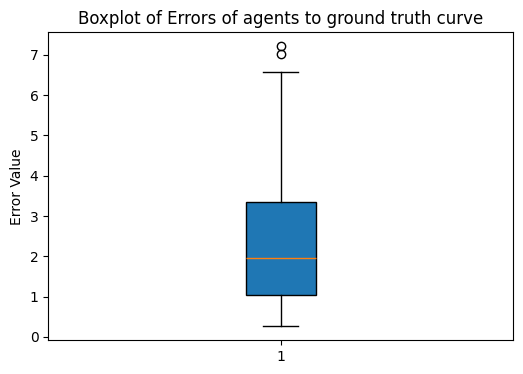

[1.5128065  1.0289167  2.2019591  0.8590346  2.021151   1.9355593
 0.26639974 1.0503802  2.7109578  3.505084   1.8089961  2.2238145
 2.925846   5.292355   6.6374946  3.7826712  2.9435377  1.8291585
 0.5147186  1.3814279  0.79061383 3.377474   1.589813   2.2348697
 1.4549226  1.639114   7.2738357  5.8801804  3.5240757  3.1861322
 2.454831   1.4201902  1.0918739  0.5958869  0.62801605 2.818789
 0.97194344 2.7727444  1.8502314  7.0798903  5.521036   1.3814292
 0.97090214 3.407003   2.9262345  4.696336   0.8377023  4.7754235
 0.5265557  1.8523107  2.6296568  3.5183496  4.0573926  0.39647773
 0.71777076 0.67042226 2.2058637  3.8885536  1.58279    0.74144506]


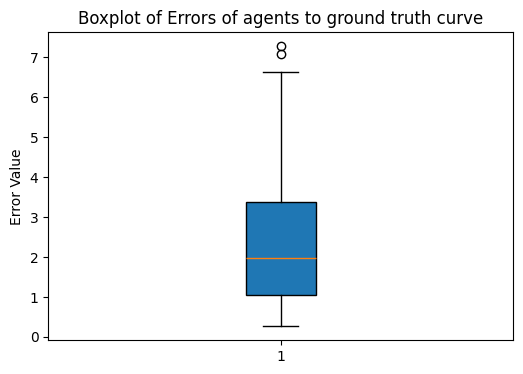

[ 2.2714837  1.5449215  3.3062482  1.2898431  3.0347645  2.906248
  0.4        1.577149   4.0705113  5.262894   2.716213   3.3390641
  4.3931665  7.946487   9.966218   5.6796923  4.4197307  2.7464871
  0.7728515  2.074218   1.187109   5.0712876  2.387109   3.3556635
  2.1845706  2.4611347 10.921686   8.829109   5.29141    4.783987
  3.685936   2.13242    1.639452   0.894726   0.942968   4.23242
  1.459376   4.1632843  2.7781281 10.630476   8.289852   2.07422
  1.4578125  5.115625   4.39375    7.0515623  1.2578125  7.1703124
  0.790625   2.78125    3.9484375  5.2828126  6.0921874  0.5953125
  1.077735   1.006641   3.312111   5.838675   2.376564   1.113282 ]


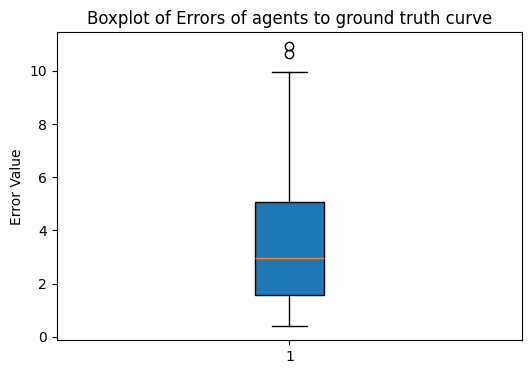

INFO:Logger:===== Evaluation Summary =====
INFO:Logger:Average Closest Distance Across Agents: 7.98
INFO:Logger:Average Furthest Distance Across Agents: 26.95


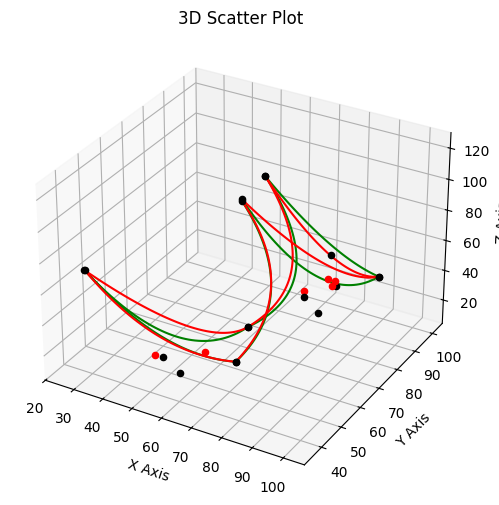

In [ ]:
run_test(config)

Experiment 4: CommNet - work alone

In [ ]:
config.experiment = Experiment.WORK_ALONE
config.model_type = "CommNet"

In [ ]:
run_training(config)

In [ ]:
run_test(config)

Experiment 5: CommNet - share positions

In [ ]:
config.experiment = Experiment.SHARE_POSITIONS

In [ ]:
run_training(config)

In [ ]:
run_test(config)

Experiment 6: CommNet - share pairwise

In [ ]:
config = ExperimentConfig(model_type="CommNet",
                          max_steps=200,
                          image_interval=1,
                          episodes=100,
                          agents=6,
                          evaluation_steps=40,
                          evaluation_interval=20,
                          decay=80, # EPSILON = MIN_EPS - (MAX_EPS - MIN_EPS) * e^(-1 * current_step / decay)
                          attention=False,
                          experiment=Experiment.SHARE_PAIRWISE,
                          use_unet=False,
                          unet_init_features=16,
                          n_sample_points=5
                          )

DEBUG:Logger:Loading image n132
INFO:Logger:Episode 1: Total Reward = 8.74 | Final Avg Distance 15.75 | Distances in mm [1.82 3.62 0.83 3.95 5.72 1.56] | Avg Closest Point = 2.96 | Avg Furthest Point = 27.93
DEBUG:Logger:Loading image n10
INFO:Logger:Episode 2: Total Reward = 10.50 | Final Avg Distance 12.96 | Distances in mm [2.19 3.41 1.55 3.09 2.61 1.29] | Avg Closest Point = 5.52 | Avg Furthest Point = 25.19
DEBUG:Logger:Loading image p8
INFO:Logger:Episode 3: Total Reward = -3.83 | Final Avg Distance 24.42 | Distances in mm [7.18 7.97 9.76 6.26 9.92 4.28] | Avg Closest Point = 9.77 | Avg Furthest Point = 28.55
DEBUG:Logger:Loading image n150
INFO:Logger:Episode 4: Total Reward = 6.18 | Final Avg Distance 20.85 | Distances in mm [4.53 4.91 2.79 5.31 7.7  0.93] | Avg Closest Point = 12.88 | Avg Furthest Point = 32.20
DEBUG:Logger:Loading image n34
INFO:Logger:Episode 5: Total Reward = 6.06 | Final Avg Distance 19.97 | Distances in mm [4.51 3.   3.04 1.41 2.99 5.49] | Avg Closest Poi

average error across all agents is 3.4476046562194824 mm


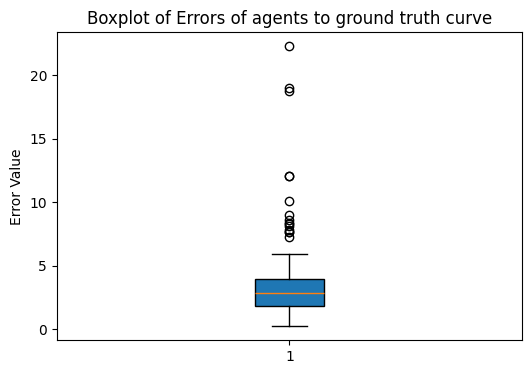

average error across all agents is 5.224176406860352 mm


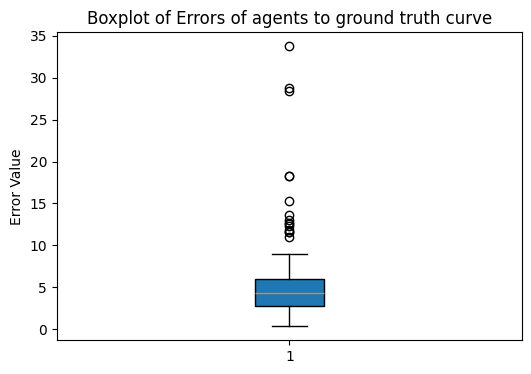

INFO:Logger:===== Evaluation Summary =====
INFO:Logger:Average Closest Distance Across Agents: 7.64
INFO:Logger:Average Furthest Distance Across Agents: 24.53
DEBUG:Logger:Loading image n119
INFO:Logger:Episode 21: Total Reward = 17.64 | Final Avg Distance 6.32 | Distances in mm [1.01 0.84 0.88 1.01 0.74 1.78] | Avg Closest Point = 4.17 | Avg Furthest Point = 26.43
DEBUG:Logger:Loading image n145
INFO:Logger:Episode 22: Total Reward = 20.00 | Final Avg Distance 6.14 | Distances in mm [1.22 1.45 1.09 0.37 2.05 0.88] | Avg Closest Point = 3.68 | Avg Furthest Point = 26.22
DEBUG:Logger:Loading image p33
INFO:Logger:Episode 23: Total Reward = 5.98 | Final Avg Distance 20.11 | Distances in mm [3.58 7.75 2.74 4.78 5.41 3.05] | Avg Closest Point = 6.78 | Avg Furthest Point = 31.51
DEBUG:Logger:Loading image n68
INFO:Logger:Episode 24: Total Reward = 17.81 | Final Avg Distance 9.42 | Distances in mm [2.28 1.69 0.99 3.42 0.59 1.74] | Avg Closest Point = 5.18 | Avg Furthest Point = 31.03
DEBUG:L

average error across all agents is 3.079308271408081 mm


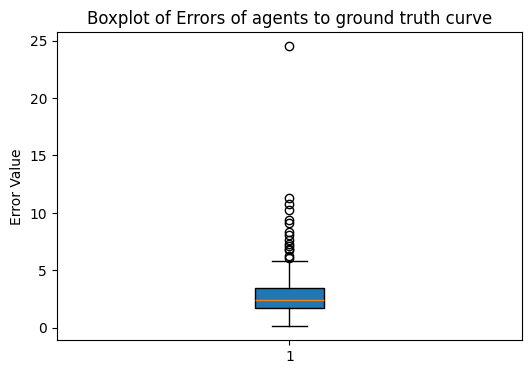

average error across all agents is 4.666094779968262 mm


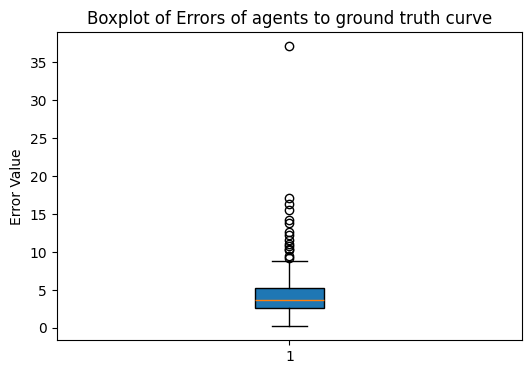

INFO:Logger:===== Evaluation Summary =====
INFO:Logger:Average Closest Distance Across Agents: 6.96
INFO:Logger:Average Furthest Distance Across Agents: 24.47
DEBUG:Logger:Loading image n28
INFO:Logger:Episode 41: Total Reward = 15.13 | Final Avg Distance 14.74 | Distances in mm [2.58 5.56 5.11 1.92 1.12 2.87] | Avg Closest Point = 5.69 | Avg Furthest Point = 31.88
DEBUG:Logger:Loading image p17
INFO:Logger:Episode 42: Total Reward = 20.35 | Final Avg Distance 9.62 | Distances in mm [1.81 2.02 2.57 1.67 1.28 2.04] | Avg Closest Point = 4.38 | Avg Furthest Point = 30.91
DEBUG:Logger:Loading image n114
INFO:Logger:Episode 43: Total Reward = 16.89 | Final Avg Distance 13.36 | Distances in mm [3.05 2.66 4.67 1.78 2.29 2.64] | Avg Closest Point = 2.95 | Avg Furthest Point = 32.63
DEBUG:Logger:Loading image n58
INFO:Logger:Episode 44: Total Reward = 24.64 | Final Avg Distance 5.77 | Distances in mm [0.39 1.54 0.77 1.29 1.82 1.15] | Avg Closest Point = 3.99 | Avg Furthest Point = 31.61
DEBUG:

average error across all agents is 3.3899989128112793 mm


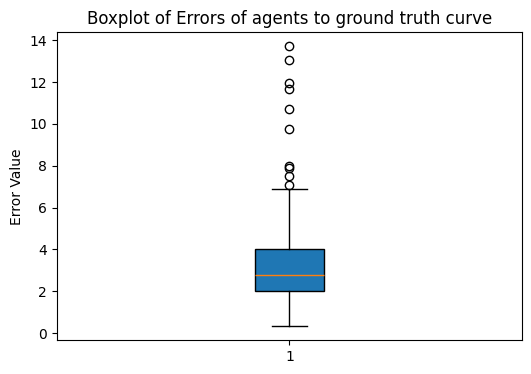

average error across all agents is 5.136886119842529 mm


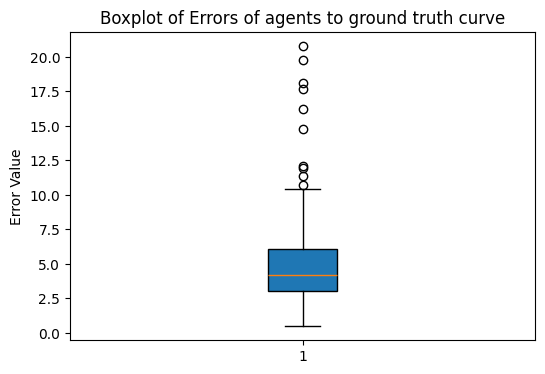

INFO:Logger:===== Evaluation Summary =====
INFO:Logger:Average Closest Distance Across Agents: 8.78
INFO:Logger:Average Furthest Distance Across Agents: 24.55
DEBUG:Logger:Loading image n148
INFO:Logger:Episode 61: Total Reward = 15.47 | Final Avg Distance 15.83 | Distances in mm [5.79 3.8  4.64 1.68 2.06 3.05] | Avg Closest Point = 7.22 | Avg Furthest Point = 35.85
DEBUG:Logger:Loading image n108
INFO:Logger:Episode 62: Total Reward = 9.21 | Final Avg Distance 16.33 | Distances in mm [3.61 3.67 3.29 1.48 1.76 3.95] | Avg Closest Point = 4.69 | Avg Furthest Point = 29.97
DEBUG:Logger:Loading image n37
INFO:Logger:Episode 63: Total Reward = 5.49 | Final Avg Distance 20.37 | Distances in mm [ 4.21  2.42  2.96  2.04 11.84  1.54] | Avg Closest Point = 4.30 | Avg Furthest Point = 32.20
DEBUG:Logger:Loading image n55
INFO:Logger:Episode 64: Total Reward = 20.04 | Final Avg Distance 12.55 | Distances in mm [3.09 1.83 1.73 2.75 2.   2.33] | Avg Closest Point = 3.46 | Avg Furthest Point = 34.13

average error across all agents is 2.6784679889678955 mm


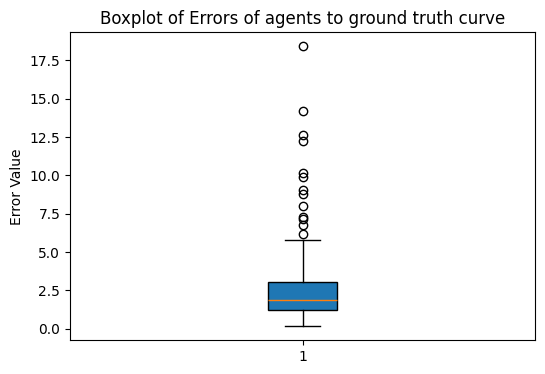

average error across all agents is 4.058698654174805 mm


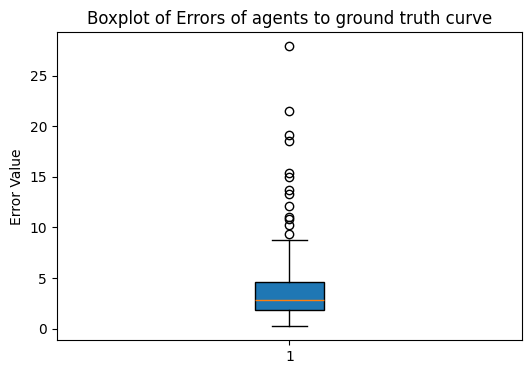

INFO:Logger:===== Evaluation Summary =====
INFO:Logger:Average Closest Distance Across Agents: 5.98
INFO:Logger:Average Furthest Distance Across Agents: 24.47
DEBUG:Logger:Loading image n107
INFO:Logger:Episode 81: Total Reward = 14.32 | Final Avg Distance 10.80 | Distances in mm [2.8  1.73 2.26 3.06 2.27 0.8 ] | Avg Closest Point = 3.68 | Avg Furthest Point = 27.17
DEBUG:Logger:Loading image n23
INFO:Logger:Episode 82: Total Reward = 25.32 | Final Avg Distance 8.36 | Distances in mm [1.15 2.82 0.6  0.77 2.53 1.27] | Avg Closest Point = 2.64 | Avg Furthest Point = 35.56
DEBUG:Logger:Loading image n81
INFO:Logger:Episode 83: Total Reward = 14.49 | Final Avg Distance 10.11 | Distances in mm [1.02 0.88 0.64 5.72 1.67 0.87] | Avg Closest Point = 3.28 | Avg Furthest Point = 26.59
DEBUG:Logger:Loading image n112
INFO:Logger:Episode 84: Total Reward = 9.43 | Final Avg Distance 24.97 | Distances in mm [3.38 2.02 7.13 4.05 3.46 4.79] | Avg Closest Point = 7.39 | Avg Furthest Point = 38.12
DEBUG

average error across all agents is 2.8959221839904785 mm


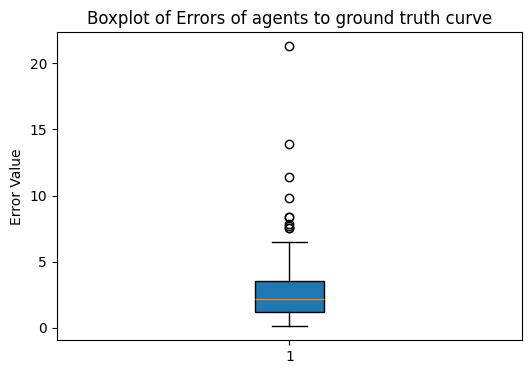

average error across all agents is 4.388208866119385 mm


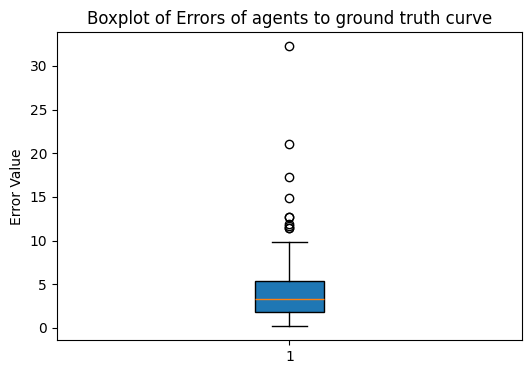

INFO:Logger:===== Evaluation Summary =====
INFO:Logger:Average Closest Distance Across Agents: 6.23
INFO:Logger:Average Furthest Distance Across Agents: 24.50


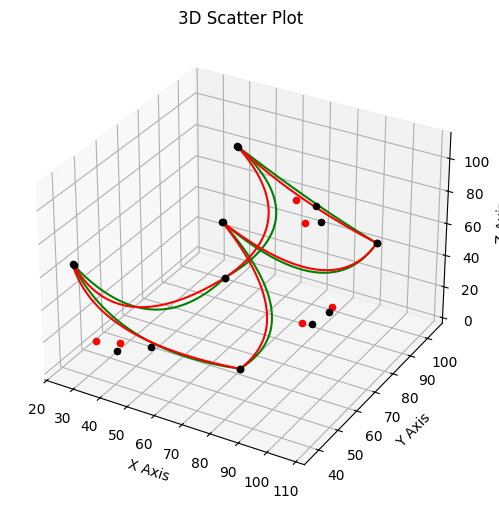

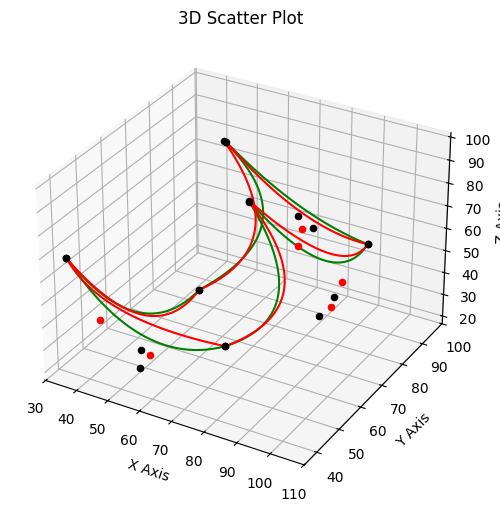

In [ ]:
run_training(config, logger=logger, dataLoader=dataLoader)

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=False)

DEBUG:Logger:Loaded Policy net CommNet-SHARE_PAIRWISE
DEBUG:Logger:Loading image p54


IndexError: list index out of range

In [ ]:
run_test(config, logger=logger, dataLoader=dataLoader, external=True)